Этот набор данных состоит из трех типов сущностей:
* (а) спецификация автомобиля с точки зрения различных характеристик,
* (б) присвоенный ему рейтинг страхового риска,
* (в) его нормированные потери при эксплуатации по сравнению с другими автомобилями.

Второй рейтинг соответствует степени, в которой автомобиль является более рискованным, чем указывает его цена. Автомобилям первоначально присваивается символ фактора риска, связанный с их ценой. Затем, если он оказывается более рискованным (или менее), этот символ корректируется путем перемещения вверх (или вниз) по шкале.
Актуарии называют этот процесс "символизацией". Значение +3 означает, что автомобиль рискованный, -3 - что он, вероятно, достаточно безопасен.
Третий фактор - это относительная средняя выплата по убытку на год застрахованного автомобиля. Эта величина нормируется для всех автомобилей в рамках определенной классификации размеров (двухдверные малые, универсалы, спортивные/специальные и т.д.) и представляет собой средний убыток на автомобиль в год.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold
from sklearn.decomposition import PCA

In [3]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):

    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)

    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="компонент", title="% доля от общей дисперсии", ylim=(0.0, 1.0)
    )

    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="компонент", title="% кумулятивная сумма", ylim=(0.0, 1.0)
    )

    fig.set(figwidth=width, dpi=dpi)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="Взаимная информация", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [4]:
df = pd.read_csv("data/Automobile_data.csv")
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [5]:
features = ["highway-mpg", "engine-size", "horsepower", "curb-weight"]
def dropNan(colname):
    df[colname] = df[colname].replace('?', np.nan)
    df.dropna(inplace=True)
def castToInt(colname):
        df[colname] = df[colname].astype(int)
for i in df.columns:
    dropNan(i)
df.drop(columns=['normalized-losses'], inplace=True)
dropNan("horsepower")
castToInt("horsepower")
dropNan("price")
castToInt("price")
X = df.copy()
y = X.pop('price')
X = X.reindex(columns = features)
# Standardize
X_scaled = (X - X.min())/(X.max() - X.min())

In [6]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"ось {i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_pca.head()

,ось 1,ось 2,ось 3,ось 4
0,0.004130,-0.099732,-0.004049,0.004654
1,0.315729,-0.084931,-0.116669,-0.029560
2,0.260814,-0.021936,-0.089897,-0.009914
3,0.477783,-0.138062,-0.080881,0.074101
4,0.023423,-0.102603,-0.034425,0.011257


In [7]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
) #коэффициенты линейной комбинации исходных переменных, из которых строятся главные компоненты
loadings

,ось 1,ось 2,ось 3,ось 4
highway-mpg,-0.484200,0.548159,0.617853,0.288668
engine-size,0.419380,0.494696,0.228932,-0.725938
horsepower,0.565340,-0.397960,0.671318,0.267115
curb-weight,0.519674,0.544449,-0.339382,0.564211


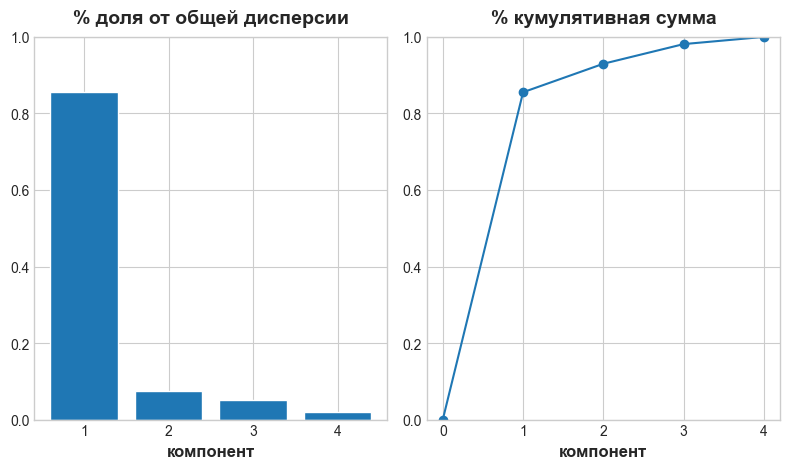

In [8]:
plot_variance(pca);

In [9]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

ось 1    1.015862
ось 2    0.172413
ось 3    0.153241
ось 4    0.134562
Name: Взаимная информация, dtype: float64

Заметим, что в оси 2 контрастирует _horsepower_ и _highway-mpg_

In [10]:
idx = X_pca['ось 2'].sort_values(ascending=False).index
cols = ["make", "fuel-type", "horsepower", "engine-type", "highway-mpg"]
df.dropna(axis=0).reset_index(drop=True).reindex(columns=cols, index=idx)

,make,fuel-type,horsepower,engine-type,highway-mpg
32,jaguar,gas,176,dohc,19
118,toyota,diesel,56,ohc,47
80,peugot,diesel,95,l,33
82,peugot,diesel,95,l,33
47,mercedes-benz,diesel,123,ohc,25
...,...,...,...,...,...
96,saab,gas,160,dohc,26
152,volvo,gas,162,ohc,22
125,toyota,gas,112,dohc,29
95,saab,gas,160,dohc,26


In [11]:
df["horsepower_mpg"] = df['horsepower'] / df['highway-mpg']

<AxesSubplot:xlabel='horsepower_mpg', ylabel='price'>

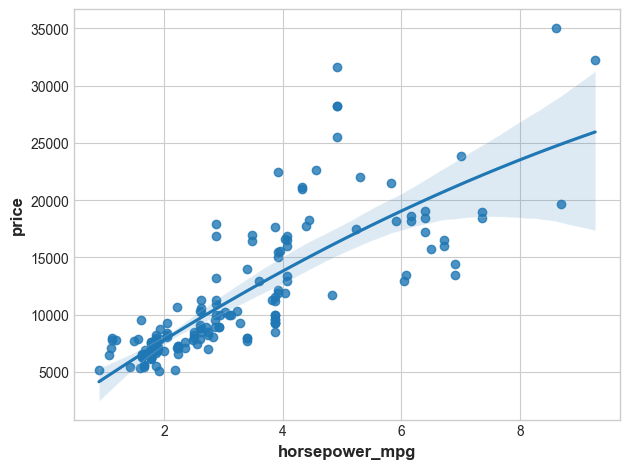

In [45]:
sns.regplot(x="horsepower_mpg", y="price", data=df, order=2)

In [41]:
numeric_df = df.select_dtypes(["float", "int"])
numeric_df

,wheel-base,length,width,height,compression-ratio,horsepower,price,horsepower_mpg
3,99.8,176.6,66.2,54.3,10.0,102,13950,3.400000
4,99.4,176.6,66.4,54.3,8.0,115,17450,5.227273
6,105.8,192.7,71.4,55.7,8.5,110,17710,4.400000
8,105.8,192.7,71.4,55.9,8.3,140,23875,7.000000
10,101.2,176.8,64.8,54.3,8.8,101,16430,3.482759
...,...,...,...,...,...,...,...,...
200,109.1,188.8,68.9,55.5,9.5,114,16845,4.071429
201,109.1,188.8,68.8,55.5,8.7,160,19045,6.400000
202,109.1,188.8,68.9,55.5,8.8,134,21485,5.826087
203,109.1,188.8,68.9,55.5,23.0,106,22470,3.925926


In [42]:
var_thres=VarianceThreshold(threshold=20)
var_thres.fit(numeric_df)
new_cols = var_thres.get_support()
numeric_df.iloc[:,new_cols]

,wheel-base,length,horsepower,price
3,99.8,176.6,102,13950
4,99.4,176.6,115,17450
6,105.8,192.7,110,17710
8,105.8,192.7,140,23875
10,101.2,176.8,101,16430
...,...,...,...,...
200,109.1,188.8,114,16845
201,109.1,188.8,160,19045
202,109.1,188.8,134,21485
203,109.1,188.8,106,22470
